In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from dotenv import load_dotenv
import seaborn as sns
from datetime import time
warnings.filterwarnings('ignore')
load_dotenv()

True

## 充電/放電過程

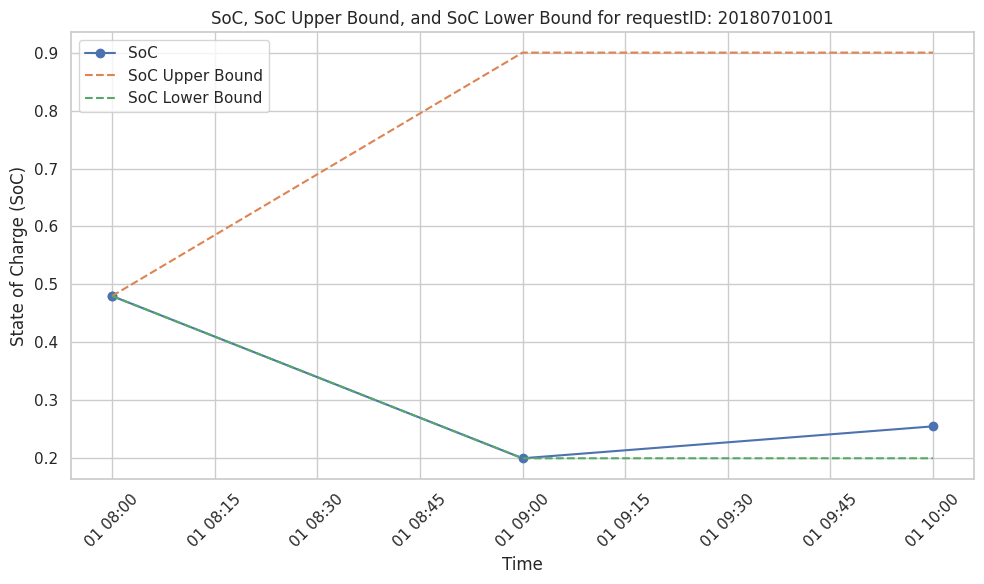

In [59]:
result_dir = './Result/TEST_alpha0.5_beta0.1_num10_s1/5/' # Replace with the desired result directory
start_date = '2018-07-01'
end_date = '2018-07-02'

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')

# Read the CSV file
soc_history_file_path = result_dir + 'test_soc_history.csv'
data = pd.read_csv(soc_history_file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

plot_soc_for_requestID(20180701001)  # Replace with the desired requestID


## 原始負載與 EV 充放電後的負載變化圖

In [60]:
# def plot_load_history(file_path, start_date, end_date):
#     # Read load history from CSV
#     load_history_df = pd.read_csv(file_path, parse_dates=['current_time'])
    
#     # Filter data by date range
#     mask = (load_history_df['current_time'] >= start_date) & (load_history_df['current_time'] <= end_date)
#     filtered_df = load_history_df.loc[mask]
    
#     # Plot original load and total load as bar charts
#     plt.figure(figsize=(14, 7))
#     bar_width = 0.4
#     bar_positions = range(len(filtered_df))
    
#     plt.bar(bar_positions, filtered_df['original_load'], width=bar_width, label='Original Load', color='blue')
#     plt.bar([p + bar_width for p in bar_positions], filtered_df['total_load'], width=bar_width, label='Load after Charging/Discharging', color='red')
    
#     plt.xlabel('Time')
#     plt.ylabel('Load (kWh)')
#     plt.title('Building Load: Original vs After Charging/Discharging')
#     plt.xticks([p + bar_width/2 for p in bar_positions], filtered_df['current_time'].dt.strftime('%Y-%m-%d %H:%M:%S'), rotation=90)
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()
    
# building_load_file_path = result_dir + 'building_loading_history.csv'  # Modify this to the path of your load history file
# plot_load_history(building_load_file_path, start_date, end_date)

## 計算建物電力成本

In [61]:
# calculate cost and penalty
def calculate_cost_and_penalty_v1(df, real_time_price, contract_capacity, capacity_price, start_time, end_time):
    # filter data by start and end time
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered = df[(df['current_time'] >= start_time) & (df['current_time'] <= end_time)].copy()
    
    # filter data by hour (7:00 - 23:00)
    df_filtered['hour'] = df_filtered['current_time'].dt.hour
    df_filtered = df_filtered[(df_filtered['hour'] >= 7) & (df_filtered['hour'] <= 23)]
    
    # merge real time price data
    df_filtered = pd.merge(df_filtered, real_time_price, how='left', left_on='current_time', right_on='datetime')

    # calculate cost
    df_filtered['cost'] = df_filtered['total_load'] * df_filtered['average_price']

    # calculate total cost
    current_tariff = df_filtered['cost'].sum()
    total_cost = current_tariff

    # calculate overload penalty
    df_filtered['month'] = df_filtered['current_time'].dt.month
    overload_penalties = []

    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[df_filtered['month'] == month]
        overload_penalty = 0
        overload = monthly_data['total_load'].max()
        
        if overload > contract_capacity:
            overload -= contract_capacity
            overload_penalty += min(overload, contract_capacity * 0.1) * capacity_price * 2  # between 0% and 10% of contract capacity
            overload -= min(overload, contract_capacity * 0.1)
            overload_penalty += overload * capacity_price * 3  # more than 10% of contract capacity
        overload_penalties.append(overload_penalty)

    total_overload_penalty = sum(overload_penalties)

    return df_filtered, total_cost, total_overload_penalty, current_tariff

# calculate cost and penalty
def calculate_cost_and_penalty_v2(df, real_time_price, contract_capacity, capacity_price, start_time, end_time):
    # filter data by start and end time
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered = df[(df['current_time'] >= start_time) & (df['current_time'] <= end_time)].copy()
    
    # filter data by hour (7:00 - 23:00)
    df_filtered['hour'] = df_filtered['current_time'].dt.hour
    df_filtered = df_filtered[(df_filtered['hour'] >= 7) & (df_filtered['hour'] <= 23)]
    
    # merge real time price data
    df_filtered = pd.merge(df_filtered, real_time_price, how='left', left_on='current_time', right_on='datetime')

    # calculate cost
    df_filtered['within_capacity_load'] =  df_filtered['total_load'].clip(upper=contract_capacity) # Load within contract capacity
    df_filtered['cost_within_capacity'] = df_filtered['within_capacity_load'] * df_filtered['average_price']
    
    # Calculate total cost (only within capacity)
    current_tariff = df_filtered['cost_within_capacity'].sum()
    total_cost = current_tariff

    # Calculate overload penalty
    df_filtered['month'] = df_filtered['current_time'].dt.month
    overload_penalties = []

    for month in df_filtered['month'].unique():
        monthly_data = df_filtered[df_filtered['month'] == month]
        overload_penalty = 0
        overload = monthly_data['total_load'].max()
        
        if overload > contract_capacity:
            overload -= contract_capacity
            overload_penalty += min(overload, contract_capacity * 0.1) * capacity_price * 2  # between 0% and 10% of contract capacity
            overload -= min(overload, contract_capacity * 0.1)
            overload_penalty += overload * capacity_price * 3  # more than 10% of contract capacity
        overload_penalties.append(overload_penalty)

    total_overload_penalty = sum(overload_penalties)

    return df_filtered, total_cost, total_overload_penalty, current_tariff

def set_real_time_price_range(real_time_price, start_time: datetime, end_time: datetime):
    real_time_price = real_time_price[(real_time_price['datetime'] >= start_time) & (real_time_price['datetime'] <= end_time)].copy()
    real_time_price.sort_values(by='datetime', inplace=True)
    return real_time_price

Total Costs by Method:
DayAhead: $5691.9646
GB-MARL: $6034.9334
MADDPG: $5936.9633
MARL-VDN: $8413.6138
MARL-IQL: $11798.6897
DDPG: $7195.4077
RandomPower: $10302.0869
Unschedule: $11402.6873


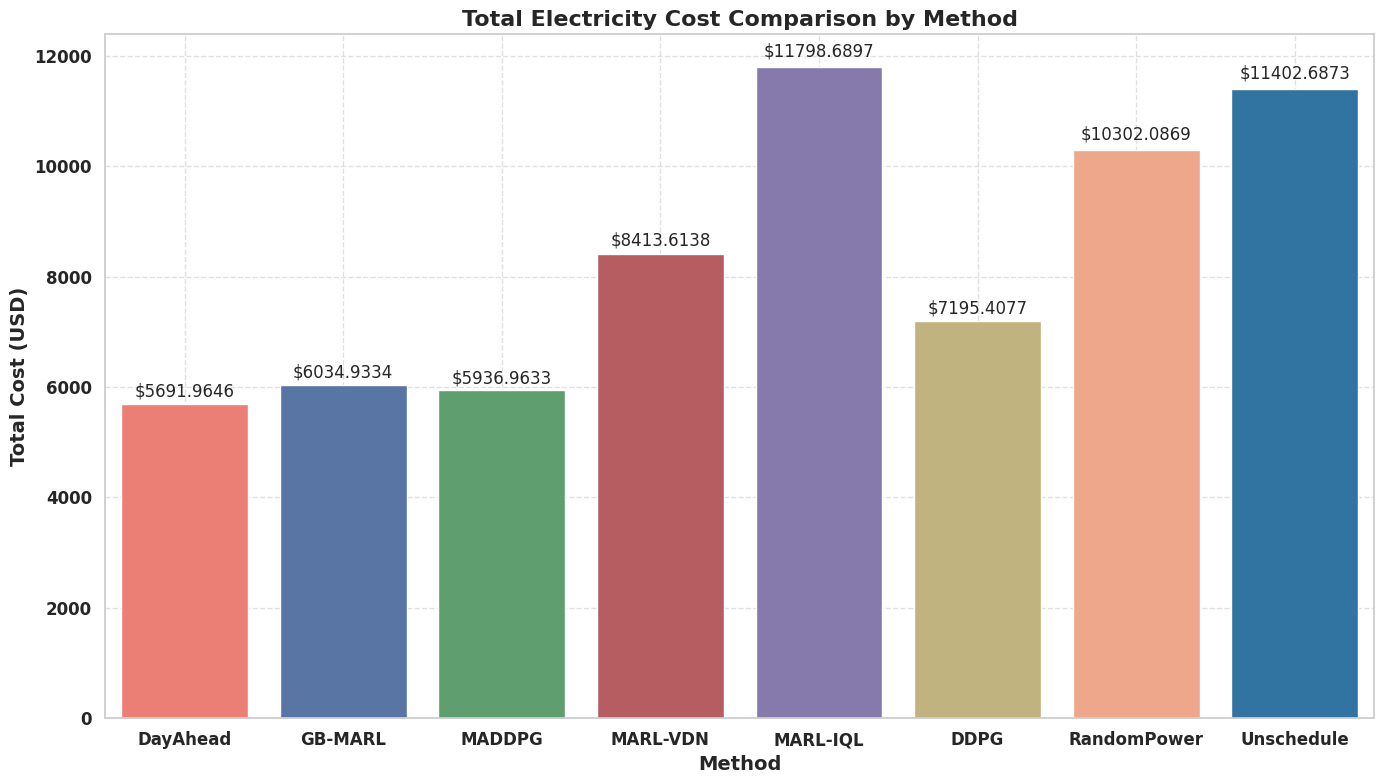

In [62]:
# set start and end datetime
start_datetime_str = '2018-09-01'
end_datetime_str = '2018-09-30'

# convert string to datetime
start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d')
end_datetime = datetime.strptime(end_datetime_str, '%Y-%m-%d')

# set contract capacity and capacity price
contract_capacity = 700
capacity_price = 15

# get real time price data
real_time_price = pd.read_csv('./Dataset/RTP/electricity_prices_from_201807010000_to_201812312359.csv')
real_time_price['datetime'] = pd.to_datetime(real_time_price['datetime'])
real_time_price = set_real_time_price_range(real_time_price, start_datetime, end_datetime)

# get building loading history result data
test_building_file = '/test_building_loading_history.csv'
test_soc_file = '/test_soc_history.csv'
test_charging_file = '/test_charging_records.csv'

building_file = '/building_loading_history.csv'
soc_file = '/soc_history.csv'
charging_file = '/charging_records.csv'


DayAhead_dir = './Result/DayAhead_09-01_09-30_num10_sim_v0/4'
GB_MARL_dir = './Result/GB-MARL-v2.1_alpha0.5_beta0.1_num10_s1/45'
MADDPG_dir = './Results/MADDPG_07-01_09-01_10_sim_v1/7'
VDN_dir = './Result/VDN-MARL_alpha0.5_beta0.1_num20_sim_v0/1'
IQL_dir = './Result/IQL-MARL_07-01_09-01_20_sim_v0/1'
DDPG_dir = './Results/DDPG/DDPG_alpha0.5_beta0.5_20_sim_v1/1'
Random_dir = './Result/RandomPower_09-01_09-30_20_sim_v0/1'
Unschedule_dir = './Result/Unschedule_09-01_09-30_20_sim_v0/1'

DayAhead_building_file = DayAhead_dir + building_file
GB_MARL_building_file = GB_MARL_dir + test_building_file
MADDPG_building_file = MADDPG_dir + test_building_file
VDN_building_file = VDN_dir + test_building_file
IQL_building_file = IQL_dir + test_building_file
DDPG_building_file = DDPG_dir + test_building_file
Random_building_file = Random_dir + building_file
Unschedule_building_file = Unschedule_dir + building_file

# set file paths and method names
methods = [DayAhead_building_file, GB_MARL_building_file, MADDPG_building_file, 
           VDN_building_file, IQL_building_file, DDPG_building_file, Random_building_file, 
           Unschedule_building_file]

method_names = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
data_frames = []

# read data
for method in methods:
    df = pd.read_csv(method)
    data_frames.append(df)
    
# calculate cost and penalty for each method
total_costs = []
overload_penalties = []
current_tariffs = []
for df, method_name in zip(data_frames, method_names):
    df_filtered, total_cost, total_overload_penalty, current_tariff = \
        calculate_cost_and_penalty_v1(df, real_time_price, contract_capacity, 
                                    capacity_price, start_datetime, end_datetime)
        
    total_cost += total_overload_penalty  # add overload penalty to total cost
    total_costs.append(total_cost)
    overload_penalties.append(total_overload_penalty)
    current_tariffs.append(current_tariff)


# set plot style
sns.set(style="whitegrid")

# define colors
colors = ['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4']

# plot total cost bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=total_costs, palette=colors, ax=ax)

# add labels and title
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Cost (USD)', fontsize=14, fontweight='bold')
ax.set_title('Total Electricity Cost Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# display total cost on top of each bar and print the value
print("Total Costs by Method:")
for bar, yval in zip(bars.patches, total_costs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, 
            f'${height:.4f}', ha='center', va='bottom', fontsize=12)
    print(f'{method_names[bars.patches.index(bar)]}: ${height:.4f}')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()

# # plot overload penalty bar chart
# fig, ax = plt.subplots(figsize=(14, 8))
# bars = sns.barplot(x=method_names, y=overload_penalties, palette=colors, ax=ax)

# # add labels and title
# ax.set_xlabel('Method', fontsize=14, fontweight='bold')
# ax.set_ylabel('Overload Penalty (USD)', fontsize=14, fontweight='bold')
# ax.set_title('Overload Penalty Comparison by Method', fontsize=16, fontweight='bold')
# ax.grid(True, linestyle='--', alpha=0.6)

# display overload penalty on top of each bar and print the value
# print("Overload Penalties by Method:")
# for bar, yval in zip(bars.patches, overload_penalties):
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, 
#             f'${height:.4f}', ha='center', va='bottom', fontsize=12)
#     print(f'{method_names[bars.patches.index(bar)]}: ${height:.4f}')

# plt.xticks(fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')
# plt.tight_layout()
# plt.show()


# fig, ax = plt.subplots(figsize=(14, 8))
# bars = sns.barplot(x=method_names, y=current_tariffs, palette=colors, ax=ax)

# ax.set_xlabel('Method', fontsize=14, fontweight='bold')
# ax.set_ylabel('Current Tariff (USD)', fontsize=14, fontweight='bold')
# ax.set_title('Current Tariff Comparison by Method', fontsize=16, fontweight='bold')
# ax.grid(True, linestyle='--', alpha=0.6)

# for bar, yval in zip(bars.patches, current_tariffs):
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)
    
# plt.xticks(fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')
# plt.tight_layout()

# plt.show()


## V1

In [63]:
# # set plot style
# sns.set(style="whitegrid")

# # define colors
# colors = ['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4']

# # plot total cost bar chart
# fig, ax = plt.subplots(figsize=(14, 8))
# bars = sns.barplot(x=method_names, y=total_costs, palette=colors, ax=ax)

# # add labels and title
# ax.set_xlabel('Method', fontsize=14, fontweight='bold')
# ax.set_ylabel('Total Cost (USD)', fontsize=14, fontweight='bold')
# ax.set_title('Total Electricity Cost Comparison by Method', fontsize=16, fontweight='bold')
# ax.grid(True, linestyle='--', alpha=0.6)

# # display total cost on top of each bar and print the value
# print("Total Costs by Method:")
# for bar, yval in zip(bars.patches, total_costs):
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, 
#             f'${height:.4f}', ha='center', va='bottom', fontsize=12)
#     print(f'{method_names[bars.patches.index(bar)]}: ${height:.4f}')

# plt.xticks(fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')
# plt.tight_layout()

# plt.show()

# # plot overload penalty bar chart
# fig, ax = plt.subplots(figsize=(14, 8))
# bars = sns.barplot(x=method_names, y=overload_penalties, palette=colors, ax=ax)

# # add labels and title
# ax.set_xlabel('Method', fontsize=14, fontweight='bold')
# ax.set_ylabel('Overload Penalty (USD)', fontsize=14, fontweight='bold')
# ax.set_title('Overload Penalty Comparison by Method', fontsize=16, fontweight='bold')
# ax.grid(True, linestyle='--', alpha=0.6)

# # display overload penalty on top of each bar and print the value
# print("Overload Penalties by Method:")
# for bar, yval in zip(bars.patches, overload_penalties):
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, 
#             f'${height:.4f}', ha='center', va='bottom', fontsize=12)
#     print(f'{method_names[bars.patches.index(bar)]}: ${height:.4f}')

# plt.xticks(fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')
# plt.tight_layout()
# plt.show()


# # fig, ax = plt.subplots(figsize=(14, 8))
# # bars = sns.barplot(x=method_names, y=current_tariffs, palette=colors, ax=ax)

# # ax.set_xlabel('Method', fontsize=14, fontweight='bold')
# # ax.set_ylabel('Current Tariff (USD)', fontsize=14, fontweight='bold')
# # ax.set_title('Current Tariff Comparison by Method', fontsize=16, fontweight='bold')
# # ax.grid(True, linestyle='--', alpha=0.6)

# # for bar, yval in zip(bars.patches, current_tariffs):
# #     height = bar.get_height()
# #     ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)
    
# # plt.xticks(fontsize=12, fontweight='bold')
# # plt.yticks(fontsize=12, fontweight='bold')
# # plt.tight_layout()

# # plt.show()


In [64]:
data_frames = []

# read data
for method in methods:
    df = pd.read_csv(method)
    data_frames.append(df)

    
# calculate cost and penalty for each method
total_costs = []
overload_penalties = []
current_tariffs = []
total_cost = 0
for df, method_name in zip(data_frames, method_names):
    df_filtered, total_cost, total_overload_penalty, current_tariff = \
        calculate_cost_and_penalty_v2(df, real_time_price, contract_capacity, 
                                    capacity_price, start_datetime, end_datetime)
        
    total_cost += total_overload_penalty  # add overload penalty to total cost
    total_costs.append(total_cost)
    overload_penalties.append(total_overload_penalty)
    current_tariffs.append(current_tariff)


## v2

Total Costs by Method:
DayAhead: $5691.9646
GB-MARL: $6034.3924
MADDPG: $5936.4464
MARL-VDN: $8409.4079
MARL-IQL: $11766.7439
DDPG: $7190.3068
RandomPower: $10267.2415
Unschedule: $11323.2001


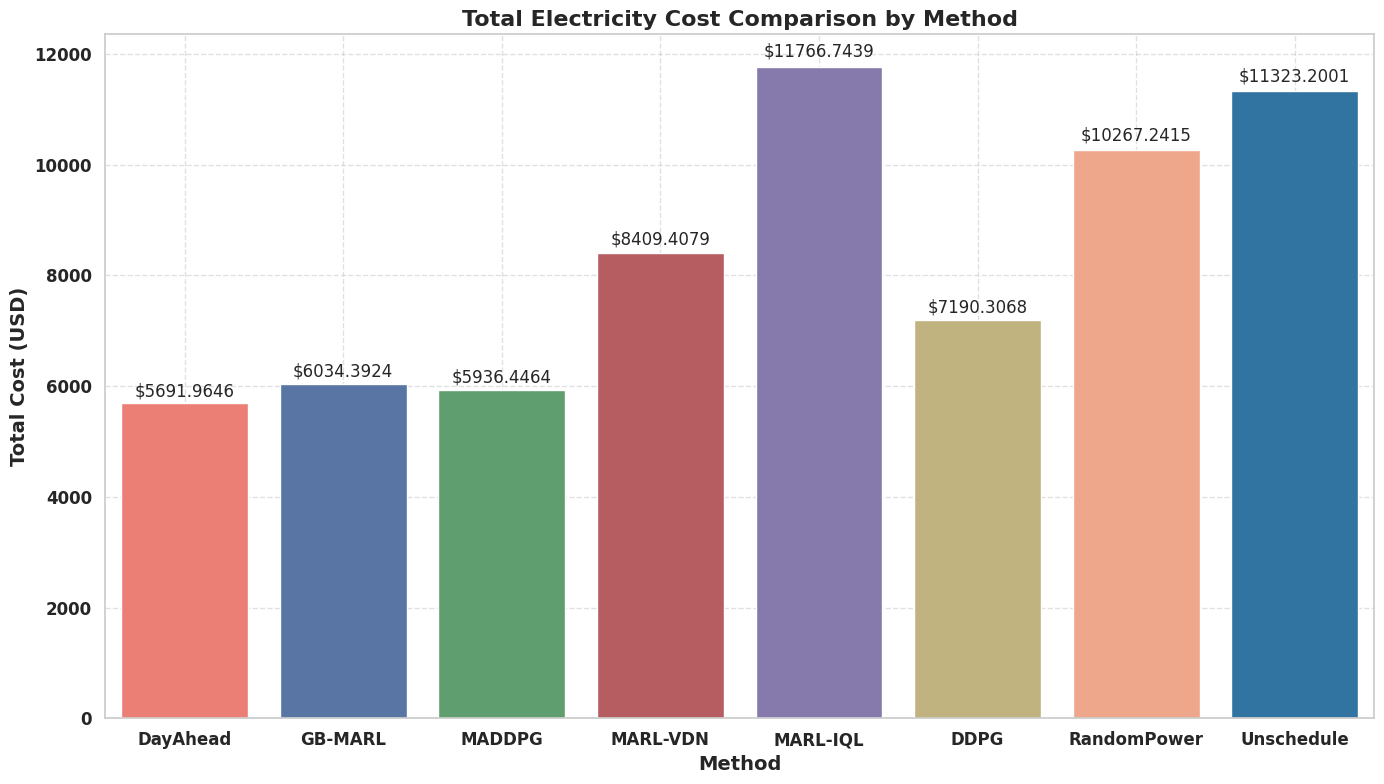

Overload Penalties by Method:
DayAhead: $0.0000
GB-MARL: $356.0557
MADDPG: $355.8429
MARL-VDN: $2271.3258
MARL-IQL: $5643.1583
DDPG: $1420.5000
RandomPower: $4172.6238
Unschedule: $5221.6263


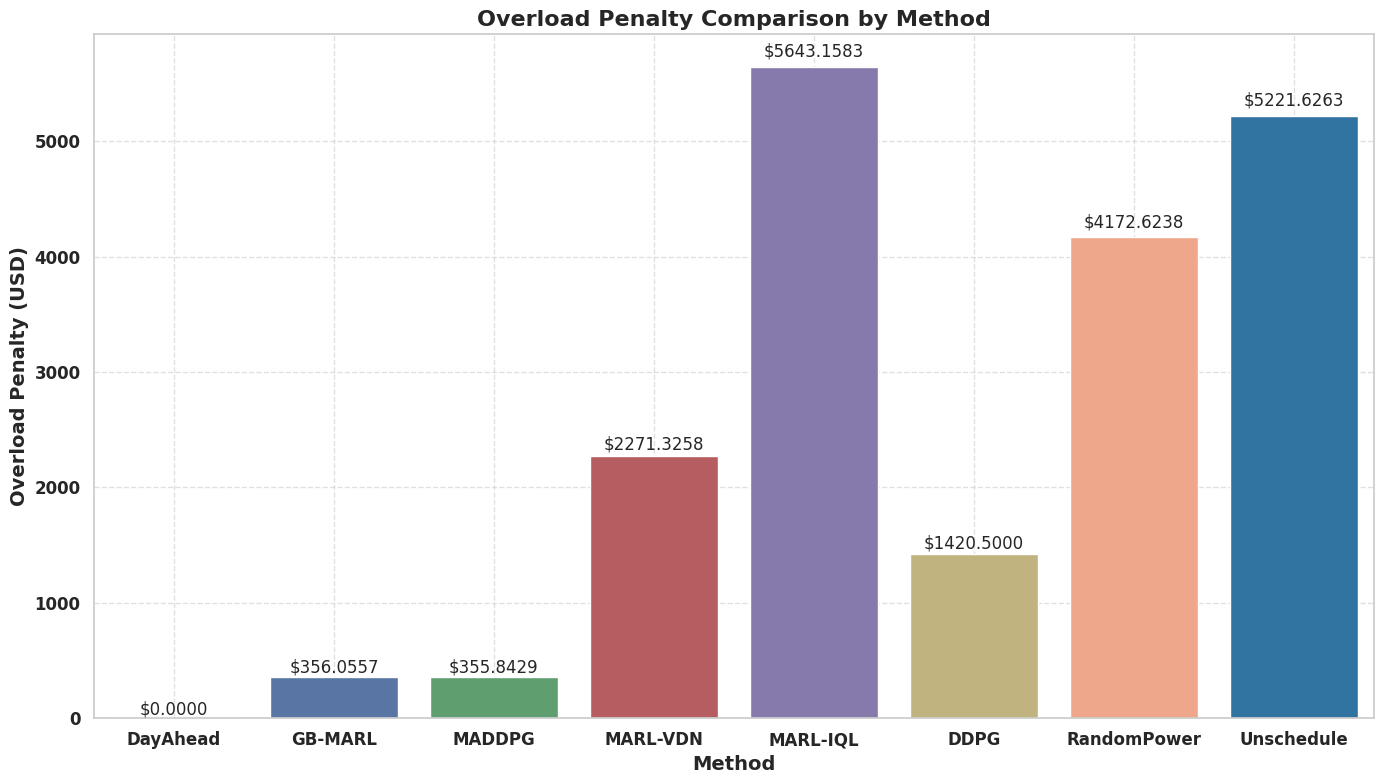

In [65]:
# set plot style
sns.set(style="whitegrid")

# define colors
colors = ['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4']

# plot total cost bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=total_costs, palette=colors, ax=ax)

# add labels and title
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Cost (USD)', fontsize=14, fontweight='bold')
ax.set_title('Total Electricity Cost Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# display total cost on top of each bar
print("Total Costs by Method:")
for bar, yval in zip(bars.patches, total_costs):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, 
            f'${height:.4f}', ha='center', va='bottom', fontsize=12)
    print(f'{method_names[bars.patches.index(bar)]}: ${height:.4f}')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()

# plot overload penalty bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=overload_penalties, palette=colors, ax=ax)

# add labels and title
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Overload Penalty (USD)', fontsize=14, fontweight='bold')
ax.set_title('Overload Penalty Comparison by Method', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# display overload penalty on top of each bar
print("Overload Penalties by Method:")
for bar, yval in zip(bars.patches, overload_penalties):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.4f}', ha='center', va='bottom', fontsize=12)
    print(f'{method_names[bars.patches.index(bar)]}: ${height:.4f}')
    
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


# fig, ax = plt.subplots(figsize=(14, 8))
# bars = sns.barplot(x=method_names, y=current_tariffs, palette=colors, ax=ax)

# ax.set_xlabel('Method', fontsize=14, fontweight='bold')
# ax.set_ylabel('Current Tariff (USD)', fontsize=14, fontweight='bold')
# ax.set_title('Current Tariff Comparison by Method', fontsize=16, fontweight='bold')
# ax.grid(True, linestyle='--', alpha=0.6)

# for bar, yval in zip(bars.patches, current_tariffs):
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'${height:.2f}', ha='center', va='bottom', fontsize=12)
    
# plt.xticks(fontsize=12, fontweight='bold')
# plt.yticks(fontsize=12, fontweight='bold')
# plt.tight_layout()

# plt.show()


## 計算波峰波谷比 (pead to valley ratio)

Peak-to-Valley Ratio for DayAhead: 7.2783
Peak-to-Valley Ratio for GB-MARL: 13.6610
Peak-to-Valley Ratio for MADDPG: 12.9139
Peak-to-Valley Ratio for MARL-VDN: 19.3325
Peak-to-Valley Ratio for MARL-IQL: 27.2169
Peak-to-Valley Ratio for DDPG: 15.4094
Peak-to-Valley Ratio for RandomPower: -66.1333
Peak-to-Valley Ratio for Unschedule: 8.7855


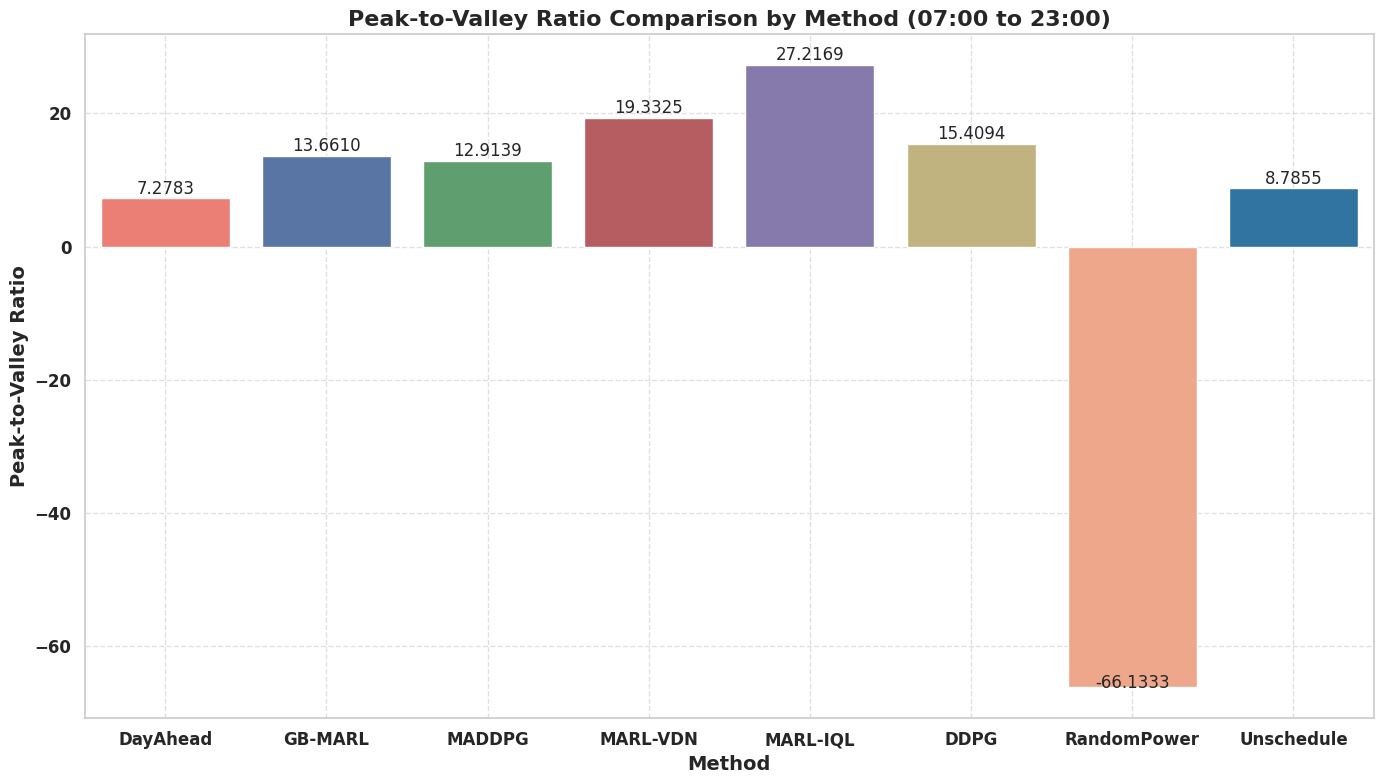

In [66]:
# calculate peak-to-valley ratio
peak_to_valley_ratios = []
for df, method_name in zip(data_frames, method_names):
    # filter data by date range
    df['current_time'] = pd.to_datetime(df['current_time'])
    df_filtered_date = df[(df['current_time'] >= start_datetime) & (df['current_time'] <= end_datetime)].copy()

    # filter data by time range (07:00 - 23:00)
    df_filtered_time = df_filtered_date[(df_filtered_date['current_time'].dt.time >= time(7, 0, 0)) & (df_filtered_date['current_time'].dt.time <= time(23, 0, 0))].copy()

    # calculate peak-to-valley ratio
    peak_load = df_filtered_time['total_load'].max()
    valley_load = df_filtered_time['total_load'].min()
    peak_to_valley_ratio = peak_load / valley_load
    peak_to_valley_ratios.append(peak_to_valley_ratio)
    print(f'Peak-to-Valley Ratio for {method_name}: {peak_to_valley_ratio:.4f}')

# set plot style
sns.set(style="whitegrid")

# define colors
colors = ['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4']

# plot peak-to-valley ratio bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bars = sns.barplot(x=method_names, y=peak_to_valley_ratios, palette=colors, ax=ax)

# add labels and title
ax.set_xlabel('Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Peak-to-Valley Ratio', fontsize=14, fontweight='bold')
ax.set_title('Peak-to-Valley Ratio Comparison by Method (07:00 to 23:00)', fontsize=16, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)

# display peak-to-valley ratio on top of each bar
for bar, yval in zip(bars.patches, peak_to_valley_ratios):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.4f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()


In [67]:
# calculate satisfaction
def calculate_satisfaction(df):
    df['satisfaction'] = df.apply(lambda x: 1 if x['final_soc'] >= x['departure_soc'] else x['final_soc'] / x['departure_soc'], axis=1)
    df['departure_time'] = pd.to_datetime(df['departure_time'])
    return df

# read data
charging_records_file = '/charging_records.csv'
DayAhead_charging_record_file = DayAhead_dir + charging_records_file
GB_MARL_charging_record_file = GB_MARL_dir + test_charging_file
MADDPG_charging_record_file = MADDPG_dir + test_charging_file
VDN_charging_record_file = VDN_dir + test_charging_file
IQL_charging_record_file = IQL_dir + test_charging_file
DDPG_charging_record_file = DDPG_dir + test_charging_file
Random_charging_record_file = Random_dir + charging_records_file
Unschedule_charging_record_file = Unschedule_dir + charging_records_file

methods = [DayAhead_charging_record_file, GB_MARL_charging_record_file, MADDPG_charging_record_file, VDN_charging_record_file, 
           IQL_charging_record_file, DDPG_charging_record_file, Random_charging_record_file, Unschedule_charging_record_file]
method_names = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
data_frames = []

for method in methods:
    df = pd.read_csv(method)
    df = calculate_satisfaction(df)
    data_frames.append(df)

## Satisfication 1

In [68]:
# calculate midway satisfaction
def calculate_midway_satisfaction(df, start_date, end_date):
    # calculate midway time for each requestID
    # print(df['current_time'])
    df['current_time'] = pd.to_datetime(df['current_time'])
    midway_time = df.groupby('requestID')['current_time'].apply(lambda x: x.min() + (x.max() - x.min()) / 2)
    
    # filter midway time by date range
    midway_time = midway_time[(midway_time >= start_date) & (midway_time < end_date)]

    # calculate satisfaction for each requestID
    satisfaction = []
    for requestID, mid_time in midway_time.items():
        mid_time_index = (df['requestID'] == requestID) & (df['current_time'] == mid_time)
        if not mid_time_index.any():
            # find the closest row to the midway time
            closest_index = (df['requestID'] == requestID) & (df['current_time'] >= start_date) & (df['current_time'] < end_date)
            closest_row = df[closest_index].iloc[(df[closest_index]['current_time'] - mid_time).abs().argsort()[:1]]
            midway_soc = closest_row['soc'].values[0]
        else:
            midway_soc = df[mid_time_index]['soc'].values[0]
        satisfaction.append(midway_soc / 0.9)
    
    return pd.Series(satisfaction)

# read data
soc_file = '/soc_history.csv'
DayAhead_soc_file_file = DayAhead_dir + soc_file
GB_MARL_soc_file_file = GB_MARL_dir + test_soc_file
MADDPG_soc_file_file = MADDPG_dir + test_soc_file
VDN_soc_file_file = VDN_dir + test_soc_file
IQL_soc_file_file = IQL_dir + test_soc_file
DDPG_soc_file_file = DDPG_dir + test_soc_file
Random_soc_file_file = Random_dir + soc_file
Unschedule_soc_file_file = Unschedule_dir + soc_file


methods = [DayAhead_soc_file_file, GB_MARL_soc_file_file, MADDPG_soc_file_file, VDN_soc_file_file, 
           IQL_soc_file_file, DDPG_soc_file_file, Random_soc_file_file, Unschedule_soc_file_file]
method_names = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
data_frames = []

Average Satisfaction by Method:
DayAhead: 0.5377
GB-MARL: 0.4798
MADDPG: 0.2710
MARL-VDN: 0.5186
MARL-IQL: 0.6318
DDPG: 0.5168
RandomPower: 0.6239
Unschedule: 1.0000


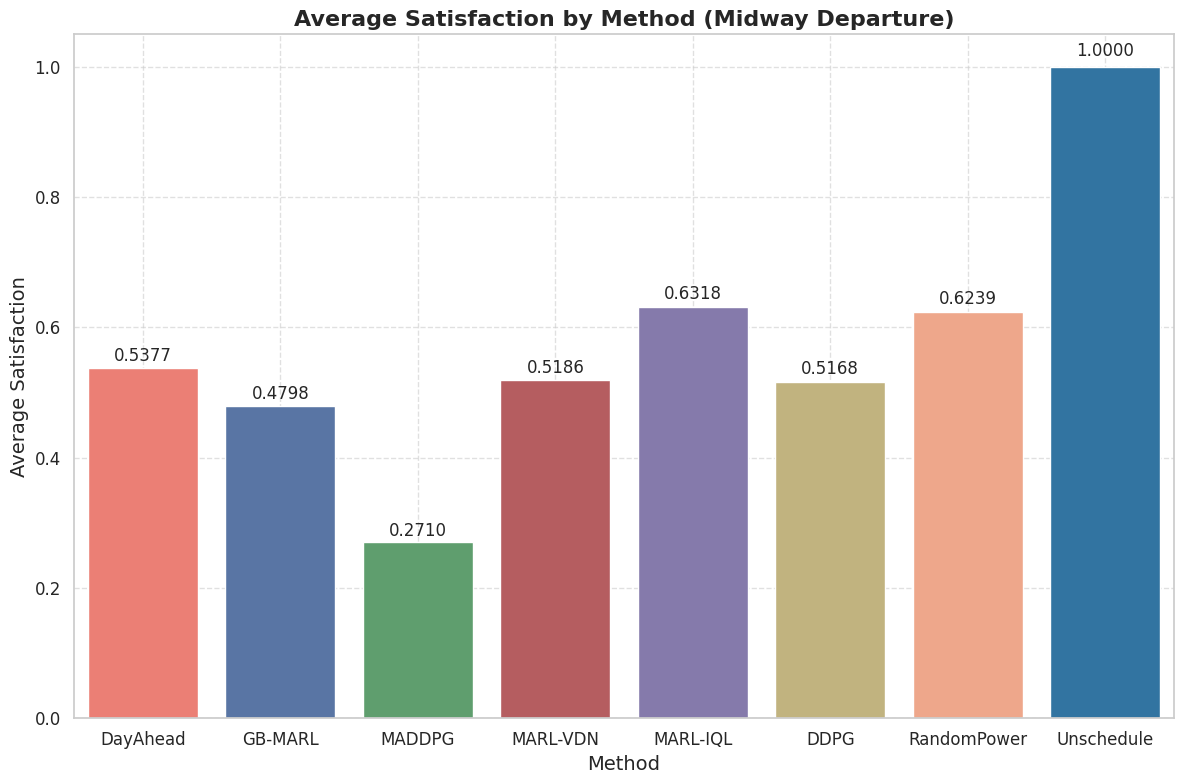

In [69]:
for method in methods:
    df = pd.read_csv(method)
    satisfaction = calculate_midway_satisfaction(df, start_datetime, end_datetime)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction by Method:")
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

sns.set(style="whitegrid")
# plot average satisfaction bar chart
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4'])

# add labels and title
plt.xlabel('Method', fontsize=14)
plt.ylabel('Average Satisfaction', fontsize=14)
plt.title(f'Average Satisfaction by Method (Midway Departure)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# display average satisfaction on top of each bar
for bar, yval in zip(bars.patches, avg_satisfaction):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.4f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()
plt.show()

## Satisfication 2

In [70]:
# calculate midway satisfaction
def calculate_midway_satisfaction_2(df, start_date, end_date, charging_records_df):
    # convert current_time to datetime
    df['current_time'] = pd.to_datetime(df['current_time'])
    charging_records_df['departure_time'] = pd.to_datetime(charging_records_df['departure_time'])
    charging_records_df['arrival_time'] = pd.to_datetime(charging_records_df['arrival_time'])
    
    # calculate midway time for each requestID
    max_time_df = df.groupby('requestID')['current_time'].apply(lambda x: x.max())
    # filter midway time by date range
    max_time_df = max_time_df[(max_time_df >= start_date) & (max_time_df < end_date)]
    # calculate satisfaction2 for each requestID
    satisfaction2 = []
    for requestID, max_time in max_time_df.items():
        # Get SoC at the earliest time (arrival) and the latest time (departure) for each requestID
        soc_initial = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[0]['soc']  # SoC at arrival (earliest time)
        soc_final = charging_records_df[charging_records_df['requestID'] == requestID]['departure_soc'].values[0]  # SoC at departure (latest time)
        
        # Get SoC at the unexpected time
        max_time_index = (df['requestID'] == requestID) & (df['current_time'] == max_time)
        
        actual_departure_soc = df[max_time_index]['soc'].values[0]
        satisfaction_value = (actual_departure_soc - soc_initial) / (soc_final - soc_initial)
        satisfaction2.append(satisfaction_value)
    
    return pd.Series(satisfaction2)


Average Satisfaction by Method:
DayAhead: 0.2791
GB-MARL: -0.0567
MADDPG: -0.7553
MARL-VDN: 1.3176
MARL-IQL: 1.4143
DDPG: 0.2770
RandomPower: 1.3946
Unschedule: 1.8091


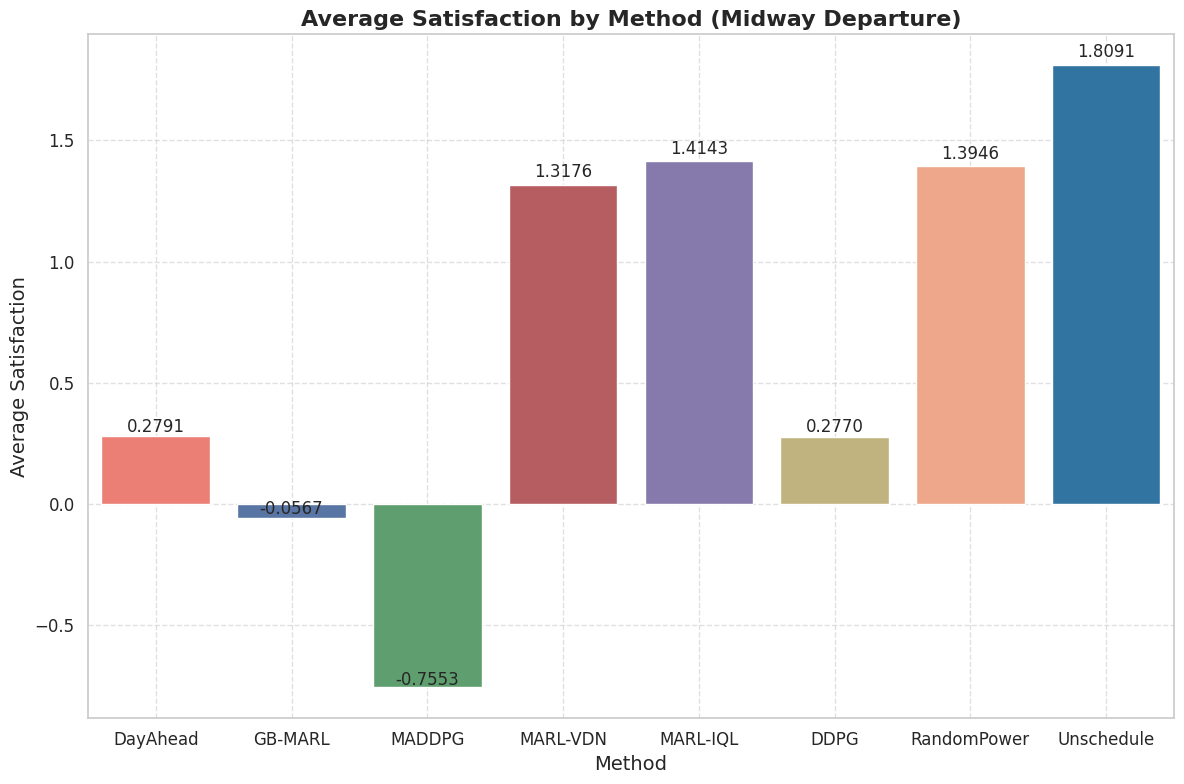

In [71]:
# read data
soc_file = '/soc_history.csv'
DayAhead_soc_file_file = DayAhead_dir + soc_file
GB_MARL_soc_file_file = GB_MARL_dir + test_soc_file
MADDPG_soc_file_file = MADDPG_dir + test_soc_file
VDN_soc_file_file = VDN_dir + test_soc_file
IQL_soc_file_file = IQL_dir + test_soc_file
DDPG_soc_file_file = DDPG_dir + test_soc_file
Random_soc_file_file = Random_dir + soc_file
Unschedule_soc_file_file = Unschedule_dir + soc_file

charging_records_file = '/charging_records.csv'
DayAhead_charging_record_file = DayAhead_dir + charging_records_file
GB_MARL_charging_record_file = GB_MARL_dir + test_charging_file
MADDPG_charging_record_file = MADDPG_dir + test_charging_file
VDN_charging_record_file = VDN_dir + test_charging_file
IQL_charging_record_file = IQL_dir + test_charging_file
DDPG_charging_record_file = DDPG_dir + test_charging_file
Random_charging_record_file = Random_dir + charging_records_file
Unschedule_charging_record_file = Unschedule_dir + charging_records_file

methods = [DayAhead_soc_file_file, GB_MARL_soc_file_file, MADDPG_soc_file_file, VDN_soc_file_file, 
           IQL_soc_file_file, DDPG_soc_file_file, Random_soc_file_file, Unschedule_soc_file_file]

charging_records_methods = [DayAhead_charging_record_file, GB_MARL_charging_record_file, MADDPG_charging_record_file, VDN_charging_record_file, 
                            IQL_charging_record_file, DDPG_charging_record_file, Random_charging_record_file, Unschedule_charging_record_file]

method_names = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
data_frames = []

for idx, method in enumerate(methods):
    df = pd.read_csv(method)
    charging_records_df = pd.read_csv(charging_records_methods[idx])
    satisfaction = calculate_midway_satisfaction_2(df, start_datetime, end_datetime, charging_records_df)
    # print(satisfaction)
    # print('-' * 50)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction by Method:")
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

sns.set(style="whitegrid")
# plot average satisfaction bar chart
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4'])

# add labels and title
plt.xlabel('Method', fontsize=14)
plt.ylabel('Average Satisfaction', fontsize=14)
plt.title(f'Average Satisfaction by Method (Midway Departure)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# display average satisfaction on top of each bar
for bar, yval in zip(bars.patches, avg_satisfaction):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.4f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()
plt.show()

## Satisfication 3

In [72]:
# calculate midway satisfaction
def calculate_midway_satisfaction_3(df, start_date, end_date, charging_records_df):
    # convert current_time to datetime
    df['current_time'] = pd.to_datetime(df['current_time'])
    charging_records_df['departure_time'] = pd.to_datetime(charging_records_df['departure_time'])
    charging_records_df['arrival_time'] = pd.to_datetime(charging_records_df['arrival_time'])
    
    # calculate midway time for each requestID
    max_time_df = df.groupby('requestID')['current_time'].apply(lambda x: x.max())
    
    # filter midway time by date range
    max_time_df = max_time_df[(max_time_df >= start_date) & (max_time_df < end_date)]

    # calculate satisfaction2 for each requestID
    satisfaction2 = []
    for requestID, max_time in max_time_df.items():
        # Get SoC at the earliest time (arrival) and the latest time (departure) for each requestID
        soc_initial = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[0]['soc']  # SoC at arrival (earliest time)
        soc_final = charging_records_df[charging_records_df['requestID'] == requestID]['departure_soc'].values[0]  # SoC at departure (latest time)
        
        # Get SoC at the unexpected time
        max_time_index = (df['requestID'] == requestID) & (df['current_time'] == max_time)
        
        actual_departure_soc = df[max_time_index]['soc'].values[0]

        # Apply the formula from the image
        r = 1 if actual_departure_soc >= soc_initial else 0
        satisfaction_value = (actual_departure_soc / soc_final) * r
        satisfaction2.append(satisfaction_value)
    
    return pd.Series(satisfaction2)


Average Satisfaction by Method:
DayAhead: 0.6642
GB-MARL: 0.5232
MADDPG: 0.1977
MARL-VDN: 1.0783
MARL-IQL: 1.1029
DDPG: 0.6132
RandomPower: 1.1024
Unschedule: 1.2095


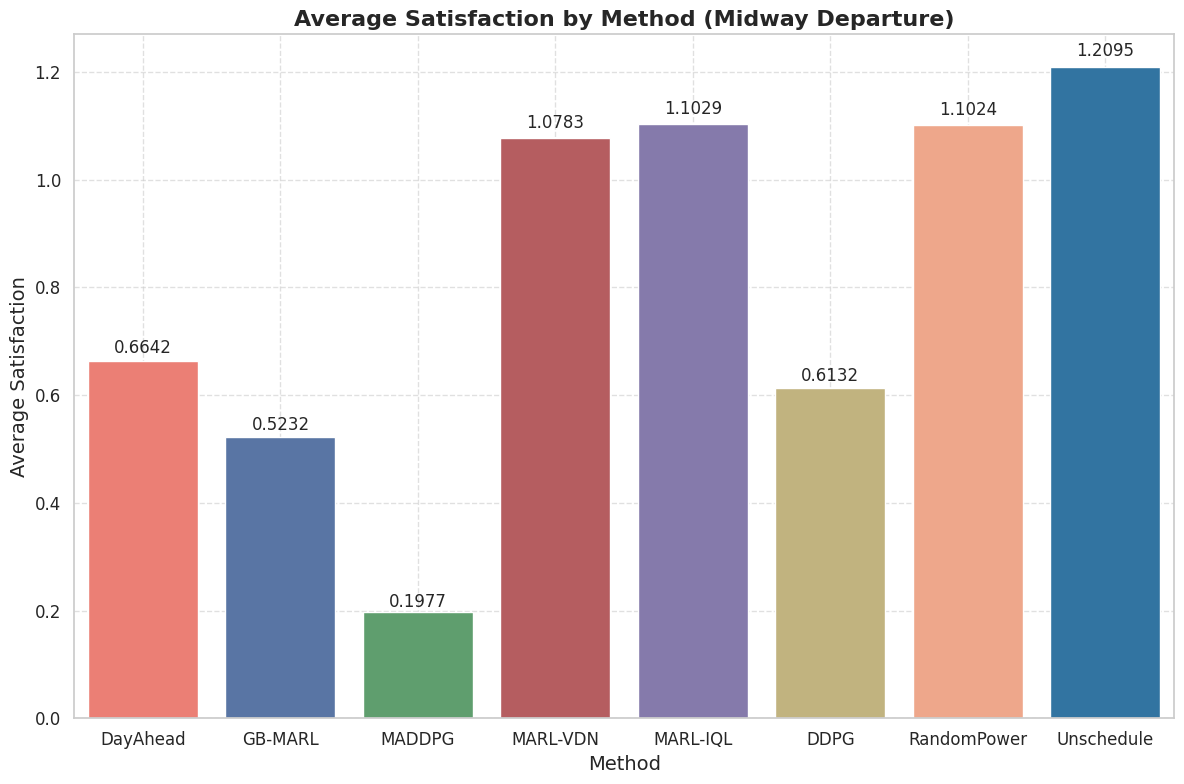

In [73]:
# read data
soc_file = '/soc_history.csv'
DayAhead_soc_file_file = DayAhead_dir + soc_file
GB_MARL_soc_file_file = GB_MARL_dir + test_soc_file
MADDPG_soc_file_file = MADDPG_dir + test_soc_file
VDN_soc_file_file = VDN_dir + test_soc_file
IQL_soc_file_file = IQL_dir + test_soc_file
DDPG_soc_file_file = DDPG_dir + test_soc_file
Random_soc_file_file = Random_dir + soc_file
Unschedule_soc_file_file = Unschedule_dir + soc_file

charging_records_file = '/charging_records.csv'
DayAhead_charging_record_file = DayAhead_dir + charging_records_file
GB_MARL_charging_record_file = GB_MARL_dir + test_charging_file
MADDPG_charging_record_file = MADDPG_dir + test_charging_file
VDN_charging_record_file = VDN_dir + test_charging_file
IQL_charging_record_file = IQL_dir + test_charging_file
DDPG_charging_record_file = DDPG_dir + test_charging_file
Random_charging_record_file = Random_dir + charging_records_file
Unschedule_charging_record_file = Unschedule_dir + charging_records_file

methods = [DayAhead_soc_file_file, GB_MARL_soc_file_file, MADDPG_soc_file_file, VDN_soc_file_file, 
           IQL_soc_file_file, DDPG_soc_file_file, Random_soc_file_file, Unschedule_soc_file_file]

charging_records_methods = [DayAhead_charging_record_file, GB_MARL_charging_record_file, MADDPG_charging_record_file, VDN_charging_record_file, 
                            IQL_charging_record_file, DDPG_charging_record_file, Random_charging_record_file, Unschedule_charging_record_file]

method_names = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
data_frames = []

for idx, method in enumerate(methods):
    df = pd.read_csv(method)
    charging_records_df = pd.read_csv(charging_records_methods[idx])
    # print(df)
    satisfaction = calculate_midway_satisfaction_3(df, start_datetime, end_datetime, charging_records_df)
    # print(satisfaction)
    # print('-' * 50)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction by Method:")
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

sns.set(style="whitegrid")
# plot average satisfaction bar chart
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4'])

# add labels and title
plt.xlabel('Method', fontsize=14)
plt.ylabel('Average Satisfaction', fontsize=14)
plt.title(f'Average Satisfaction by Method (Midway Departure)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# display average satisfaction on top of each bar
for bar, yval in zip(bars.patches, avg_satisfaction):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.4f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()
plt.show()

## Satisfication 4

In [74]:
# calculate midway satisfaction
def calculate_midway_satisfaction_4(df, start_date, end_date, charging_records_df):
    # convert current_time to datetime
    df['current_time'] = pd.to_datetime(df['current_time'])
    charging_records_df['departure_time'] = pd.to_datetime(charging_records_df['departure_time'])
    charging_records_df['arrival_time'] = pd.to_datetime(charging_records_df['arrival_time'])
    
    # calculate midway time for each requestID
    max_time_df = df.groupby('requestID')['current_time'].apply(lambda x: x.max())
    # filter midway time by date range
    max_time_df = max_time_df[(max_time_df >= start_date) & (max_time_df < end_date)]
    # calculate satisfaction2 for each requestID
    satisfaction2 = []
    for requestID, max_time in max_time_df.items():
        # Get SoC at the earliest time (arrival) and the latest time (departure) for each requestID
        soc_initial = df.loc[df['requestID'] == requestID].sort_values(by='current_time').iloc[0]['soc']  # SoC at arrival (earliest time)
        soc_final = charging_records_df[charging_records_df['requestID'] == requestID]['departure_soc'].values[0]  # SoC at departure (latest time)
        
        # Get SoC at the unexpected time
        max_time_index = (df['requestID'] == requestID) & (df['current_time'] == max_time)
        actual_departure_soc = df[max_time_index]['soc'].values[0]
        # Apply the formula from the image
        satisfaction_value = actual_departure_soc - soc_initial
        satisfaction2.append(satisfaction_value)
    
    return pd.Series(satisfaction2)


Average Satisfaction by Method:
DayAhead: 0.0845
GB-MARL: 0.0449
MADDPG: -0.1337
MARL-VDN: 0.3600
MARL-IQL: 0.3768
DDPG: 0.1033
RandomPower: 0.3770
Unschedule: 0.4522


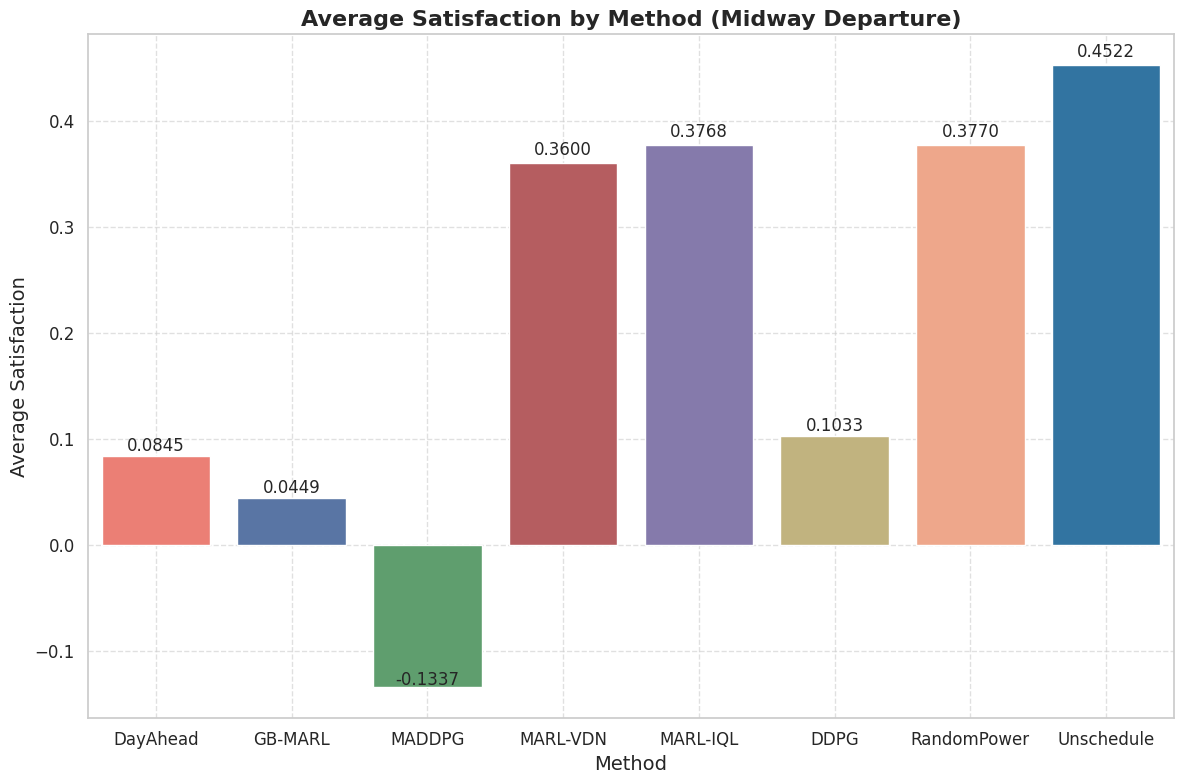

In [75]:
# read data
soc_file = '/soc_history.csv'
DayAhead_soc_file_file = DayAhead_dir + soc_file
GB_MARL_soc_file_file = GB_MARL_dir + test_soc_file
MADDPG_soc_file_file = MADDPG_dir + test_soc_file
VDN_soc_file_file = VDN_dir + test_soc_file
IQL_soc_file_file = IQL_dir + test_soc_file
DDPG_soc_file_file = DDPG_dir + test_soc_file
Random_soc_file_file = Random_dir + soc_file
Unschedule_soc_file_file = Unschedule_dir + soc_file

charging_records_file = '/charging_records.csv'
DayAhead_charging_record_file = DayAhead_dir + charging_records_file
GB_MARL_charging_record_file = GB_MARL_dir + test_charging_file
MADDPG_charging_record_file = MADDPG_dir + test_charging_file
VDN_charging_record_file = VDN_dir + test_charging_file
IQL_charging_record_file = IQL_dir + test_charging_file
DDPG_charging_record_file = DDPG_dir + test_charging_file
Random_charging_record_file = Random_dir + charging_records_file
Unschedule_charging_record_file = Unschedule_dir + charging_records_file

methods = [DayAhead_soc_file_file, GB_MARL_soc_file_file, MADDPG_soc_file_file, VDN_soc_file_file, 
           IQL_soc_file_file, DDPG_soc_file_file, Random_soc_file_file, Unschedule_soc_file_file]

method_names = ['DayAhead', 'GB-MARL', 'MADDPG', 'MARL-VDN', 'MARL-IQL', 'DDPG', 'RandomPower', 'Unschedule']
charging_records_methods = [DayAhead_charging_record_file, GB_MARL_charging_record_file, MADDPG_charging_record_file, VDN_charging_record_file, 
                            IQL_charging_record_file, DDPG_charging_record_file, Random_charging_record_file, Unschedule_charging_record_file]
data_frames = []

for idx, method in enumerate(methods):
    df = pd.read_csv(method)
    charging_records_df = pd.read_csv(charging_records_methods[idx])
    # print(df)
    satisfaction = calculate_midway_satisfaction_4(df, start_datetime, end_datetime, charging_records_df)
    # print(satisfaction)
    # print('-' * 50)
    data_frames.append(satisfaction)

# calculate average satisfaction
avg_satisfaction = [s.mean() for s in data_frames]

# print the average satisfaction for each method
print("Average Satisfaction by Method:")
for method_name, satisfaction in zip(method_names, avg_satisfaction):
    print(f'{method_name}: {satisfaction:.4f}')

sns.set(style="whitegrid")
# plot average satisfaction bar chart
plt.figure(figsize=(12, 8))
bars = sns.barplot(x=method_names, y=avg_satisfaction, palette=['#FF6F61', '#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974', '#FFA07A', '#1F77B4'])

# add labels and title
plt.xlabel('Method', fontsize=14)
plt.ylabel('Average Satisfaction', fontsize=14)
plt.title(f'Average Satisfaction by Method (Midway Departure)', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# display average satisfaction on top of each bar
for bar, yval in zip(bars.patches, avg_satisfaction):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * height, f'{height:.4f}', ha='center', va='bottom', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()
plt.show()

## 消融實驗

In [76]:

# start_time = datetime.strptime('07:00:00', '%H:%M:%S').time()
# end_time = datetime.strptime('23:00:00', '%H:%M:%S').time()

# # compare peak-to-valley ratio for each method
# methods_files = {
#     'GB-MARL': GB_MARL_building_file,
#     'MARL': MADDPG_building_file,
# }

# # calculate daily load and peak-to-valley ratio
# def calculate_daily_load_and_pvr(df):
#     df['current_time'] = pd.to_datetime(df['current_time'])
#     df['date'] = df['current_time'].dt.date
#     df['day_of_week'] = df['current_time'].dt.day_name()

#     # filter data by date range
#     df = df[(df['current_time'] >= start_datetime) & (df['current_time'] <= end_datetime)]
    
#     avg_load = {day: [] for day in df['day_of_week'].unique()}
#     pvr = {day: [] for day in df['day_of_week'].unique()}
    
#     for day in df['day_of_week'].unique():
#         df_day = df[df['day_of_week'] == day]
#         df_day_time_filtered = df_day[(df_day['current_time'].dt.time >= start_time) & (df_day['current_time'].dt.time <= end_time)]
        
#         if not df_day_time_filtered.empty:
#             avg_load[day].append(df_day_time_filtered['total_load'].mean())
#             peak_load = df_day_time_filtered['total_load'].max()
#             valley_load = df_day_time_filtered['total_load'].min()
#             pvr[day].append(peak_load / valley_load if valley_load > 0 else None)
    
#     avg_load = {day: sum(values)/len(values) for day, values in avg_load.items() if values}
#     pvr = {day: sum(values)/len(values) for day, values in pvr.items() if values}
    
#     return avg_load, pvr

# # calculate daily load and peak-to-valley ratio for each method
# all_avg_load = {}
# all_pvr = {}
# for method_name, file_path in methods_files.items():
#     df = pd.read_csv(file_path)
#     avg_load, pvr = calculate_daily_load_and_pvr(df)
#     all_avg_load[method_name] = avg_load
#     all_pvr[method_name] = pvr

# # create dataframes
# pvr_df = pd.DataFrame(all_pvr)

# # reorder days of the week
# day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# pvr_df = pvr_df.reindex(day_order)

# # set plot style
# sns.set(style="whitegrid")

# # define colors
# colors = sns.color_palette("husl", len(methods_files))

# # plot peak-to-valley ratio bar chart
# fig, ax = plt.subplots(figsize=(14, 8))

# # plot bar chart
# pvr_df.plot(kind='bar', ax=ax, color=colors, width=0.8)
# ax.set_xlabel('Day of Week', fontsize=14, fontweight='bold')
# ax.set_ylabel('Peak-to-Valley Ratio', fontsize=14, fontweight='bold')
# ax.set_title('Peak-to-Valley Ratio by Method for Each Day of the Week (07:00 to 23:00)', fontsize=16, fontweight='bold')
# ax.legend(title='Method', fontsize=12, title_fontsize=14)
# ax.grid(True, linestyle='--', alpha=0.6)

# # display peak-to-valley ratio on top of each bar
# plt.tight_layout()   
# plt.show()